In [1]:
import pandas as pd
# import numpy as np
# import random
from matplotlib import pyplot as plt
# from scipy.spatial.distance import cdist
# from qnorm import quantile_normalize
# import sklearn
# from sklearn.cluster import KMeans

from tsa.preprocessing import get_sample_info, tpm_normalization, merge_replicates
from tsa.gpr import gpr
from tsa.gene_selection import score_normalization, plot_scores, best_n_genes, cluster_genes
# from tsa.tsa import get_cost_matrix, best_alignment_graph, avg_alignment#plot_alignment, plot_gene
from tsa.bootstrap import bootstrap_alignment
from tsa.utils import inference_timeseries, all_numeric, #list2floats
# from tsa.plotting import plot_alignments

plt.rcParams['figure.figsize'] = [8, 6]

### Pinned variables
- normalization: 5 TPM minimum, quantile normalization & log transformation
- template GPR with 10 points/timepoint
- distance metric: correlation

In [2]:
tpm_file = "data/GRCz11-TPM.tsv"
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

template_samples_file = "data/white_mpf_samples.tsv"
# query_samples_file = "data/levin_mpf_samples.tsv"
query_samples_file = "data/white_mpf_samples.tsv"  # control
# query_samples_file = "data/marletaz_mpf_samples.tsv"

# currently ran for 
# 18906 genes with min(TPM) > 5 and median(TPM) > 0 (2 ConvergenceWarnings: gene 4096 and 4817)
# with 171 points (10 per original timepoint)
new_gpr = False
gpr_inference_file = "data/white_mpf_gpr.tsv"
gpr_scores_file = "data/white_mpf_score.tsv"

showcase_gene = "ENSDARG00000000212"

In [3]:
# tpm_file = "data/XT9.1-TPM.tsv"
# tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

# template_samples_file = "data/owensA1_mpf_samples.tsv"
# # query_samples_file = "data/owensA2_mpf_samples.tsv"
# query_samples_file = "data/owensB1_mpf_samples.tsv"
# # query_samples_file = "data/tanA_mpf_samples.tsv"
# # query_samples_file = "data/tanB_mpf_samples.tsv"

# new_gpr = False
# gpr_inference_file = "data/owensA1_mpf_gpr.tsv"
# gpr_scores_file = "data/owensA1_mpf_score.tsv"

# showcase_gene = "ENSXETG00000000002"

In [4]:
# # start f-ing around with stages instead of mpf

# tpm_file = "data/GRCz11-TPM.tsv"
# tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

# template_samples_file = "data/white_stage_samples.tsv"
# # query_samples_file = "data/levin_stage_samples.tsv"
# query_samples_file = "data/levin_mpf_samples.tsv"
# # query_samples_file = "data/white_stage_samples.tsv"  # control
# # query_samples_file = "data/marletaz_mpf_samples.tsv"

# # currently ran for 
# # 18906 genes with min(TPM) > 5 and median(TPM) > 0 (2 ConvergenceWarnings: gene 4096 and 4817)
# # with 171 points (10 per original timepoint)
# new_gpr = False
# gpr_inference_file = "data/white_mpf_gpr.tsv"
# gpr_scores_file = "data/white_mpf_score.tsv"

# showcase_gene = "ENSDARG00000000212"

### GPR of all template genes

In [5]:
# preprocessing
template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
template_sample_order, template_time2samples = get_sample_info(template_samples)

template_tpms = tpm_normalization(tpms, template_sample_order, min_value=5, min_median_value=0, verbose=True)

timepoints_per_sample = 10
extended_timepoints = inference_timeseries(list(template_time2samples), timepoints_per_sample)

template_tpms.head(3)

11063 genes with max below 5 TPM (34%)
2243 genes with median below or equal to 0 TPM (10%)
18906 genes, 90 samples left after filtering


,1-cell-1,1-cell-2,1-cell-3,1-cell-4,1-cell-5,2-cell-1,2-cell-2,2-cell-3,2-cell-4,2-cell-5,...,Day-4-1,Day-4-2,Day-4-3,Day-4-4,Day-4-5,Day-5-1,Day-5-2,Day-5-3,Day-5-4,Day-5-5
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000001,3.500623,3.193223,2.993834,3.134451,2.930888,3.063963,3.358324,3.177872,3.182704,3.292535,...,1.268145,0.875185,1.372952,0.953276,1.219284,1.252780,1.293310,1.701401,1.087258,0.985310
ENSDARG00000000002,1.798363,1.850706,1.549031,1.842664,1.618451,2.919417,2.731890,2.547173,2.881035,2.495728,...,2.909071,3.259391,3.423040,3.203155,2.933308,3.054464,3.049627,3.124625,2.925538,3.317229
ENSDARG00000000018,3.825139,3.883515,3.443959,3.688393,3.947403,4.004615,4.161532,4.129312,4.164329,3.913867,...,4.537668,4.042059,4.059302,4.259864,4.103876,4.459250,4.421675,4.362885,4.252356,4.371778


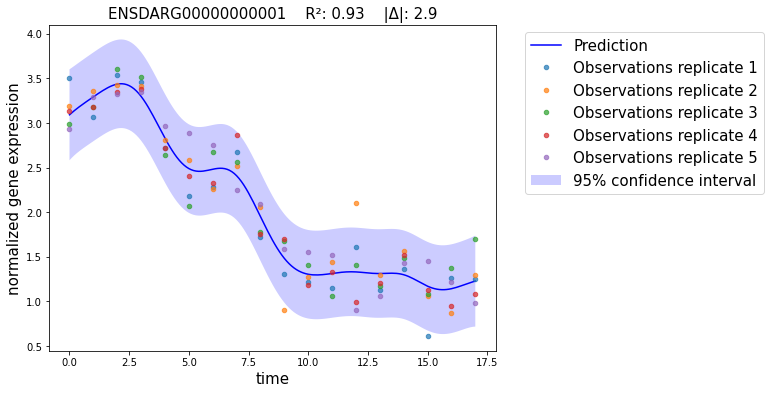

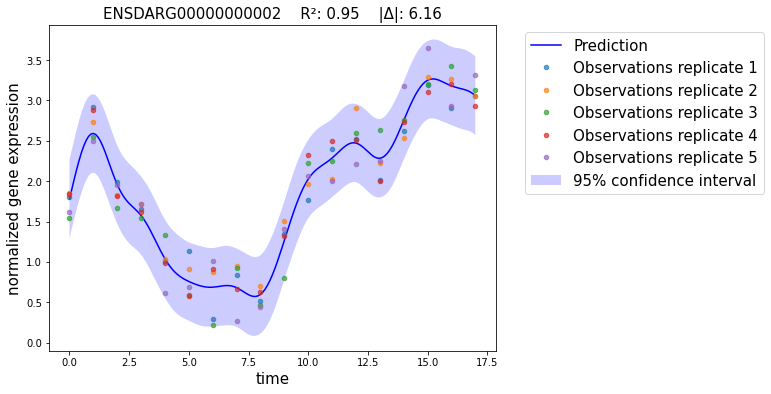

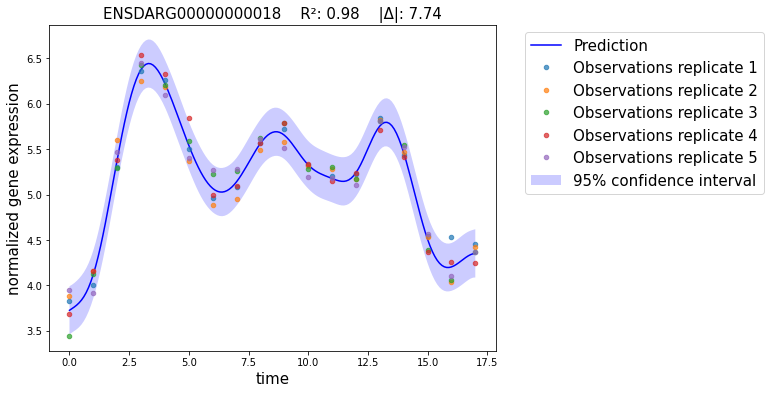

In [6]:
# run 3x with pictures
template_tpms_inf, gpr_scores = gpr(template_time2samples, template_tpms, extended_timepoints, plot=True, verbose=False, run_n=3)

if new_gpr:
    # run with all genes
    template_tpms_inf, gpr_scores = gpr(template_time2samples, template_tpms, extended_timepoints, plot=False, verbose=True, run_n=None)
    
    template_tpms_inf.to_csv(gpr_inference_file, sep="\t")
    gpr_scores.to_csv(gpr_scores_file, sep="\t")
else:
    template_tpms_inf = pd.read_csv(gpr_inference_file, sep="\t", index_col=0)
    gpr_scores = pd.read_csv(gpr_scores_file, sep="\t", index_col=0)

In [7]:
# # conver mpf to stage annotation (to test bad data)

# tps = list(template_samples.time.unique())
# tps2 = []
# for t in tps:
#     tps2.append(t)
#     for n in range(10)[1:]:
#         tps2.append(f"{t}+{n}/{10}")
        
# tps2 = tps2[:-9]
# template_tpms_inf.columns = tps2

# template_tpms_inf

### optional: filter template genes by r2, variability or both
- I filter on model accuracy only here

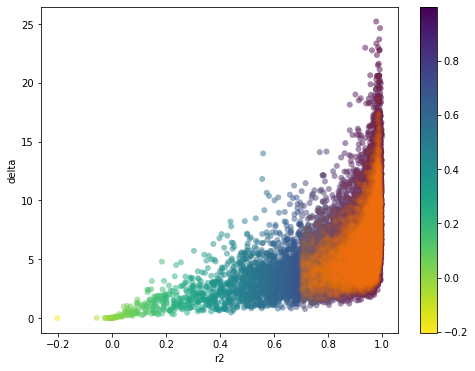

In [8]:
# remove genes that cannot weren't modelled accurately
weight_expr=0
min_r2 = 0.7
weight_r2=1

gpr_normscores = score_normalization(gpr_scores, weight_expr, weight_r2)
top_template_genes = gpr_normscores[gpr_normscores.r2 >= min_r2].index.to_list()
plot_scores(gpr_normscores, highlight_top_n=len(top_template_genes))

# n = 12_000
# top_template_genes = best_n_genes(gpr_normscores, n)
# gpr_normscores = score_normalization(gpr_scores, weight_expr=1, weight_r2=3)
# plot_scores(gpr_normscores, highlight_top_n=n)

### filter for overlapping (expressed) genes

In [9]:
# preprocessing
query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(query_samples)

target_distribution = template_tpms[template_tpms.columns[0]].to_list()
query_tpms = tpm_normalization(tpms, sample_order, min_value=5, min_median_value=0, qnorm_target_dist=target_distribution)

# TODO: other methods, such as GPR?
query_tpms = merge_replicates(query_tpms, time2samples, how="median")

if all_numeric(time2samples):
    # convert time to numeric
    samples2time = query_samples.to_dict()["time"]
    query_tpms = query_tpms.rename(columns=samples2time)
    
query_tpms.head(3)

11063 genes with max below 5 TPM (34%)
2243 genes with median below or equal to 0 TPM (10%)
18906 genes, 90 samples left after filtering


,0.0,45.0,135.0,180.0,259.8,315.0,360.0,480.0,619.8,960.0,1140.0,1440.0,1800.0,2160.0,2880.0,4320.0,5760.0,7200.0
gene,,,,,,,,,,,,,,,,,,
ENSDARG00000000001,2.047696,2.064436,2.145290,2.140686,1.895346,1.769946,1.734762,1.832349,1.473569,1.369826,0.799732,0.799732,0.799732,0.799732,1.313080,0.799732,0.799732,0.799732
ENSDARG00000000002,1.484583,1.899906,1.500300,1.411945,0.799732,0.799732,0.799732,0.799732,0.799732,0.799732,1.616649,1.701062,1.814771,1.691126,1.901792,2.072261,2.071473,2.019511
ENSDARG00000000018,2.270570,2.358765,2.673979,2.892862,2.848880,2.701738,2.583569,2.606758,2.715901,2.748011,2.659057,2.633716,2.624855,2.767261,2.692636,2.469075,2.351593,2.425400


### Bootstrapping: Goodness of Fit

In [10]:
# intersection of query genes & top template genes
query_genes = query_tpms.index
starting_genes = set(top_template_genes).intersection(query_genes)

print(len(starting_genes), "overlapping genes")

template_gene_clusters = cluster_genes(template_tpms_inf, starting_genes)

17238 overlapping genes


In [11]:
# avg_path = avg_alignment(template_tpms_inf, query_tpms, template_gene_clusters, tries=2, frac=0.01)

In [13]:
# top_gene_clusters, _ = top_cluster_genes(template_tpms_inf, query_tpms, path=avg_path, gene_cluster_df=template_gene_clusters)
# avg_path = avg_alignment(template_tpms_inf, query_tpms, top_gene_clusters, tries=1)

Cycle 1, using all 17238 genes.

Average TSA of 2 alignments with 20% of genes per cluster 
(57 clusters, 3451 total genes)


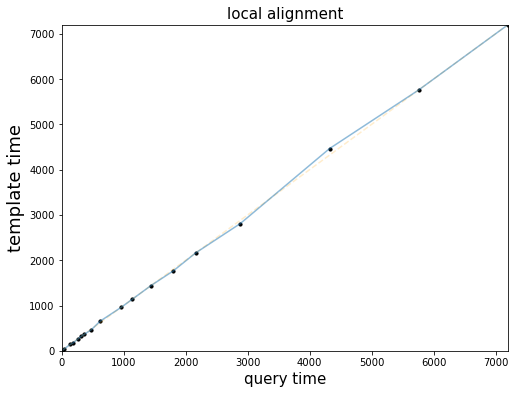

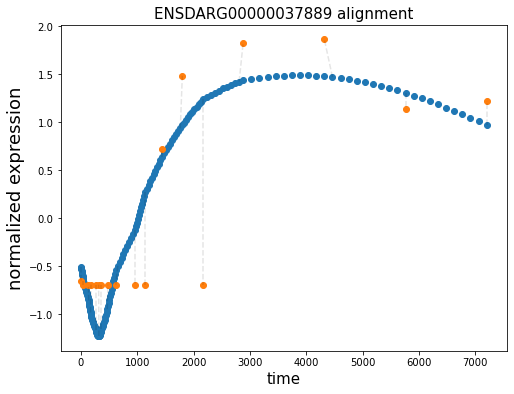

Cycle 2, using the best 3422 of 17238 genes.

Average TSA of 2 alignments with 20% of genes per cluster 
(57 clusters, 686 total genes)


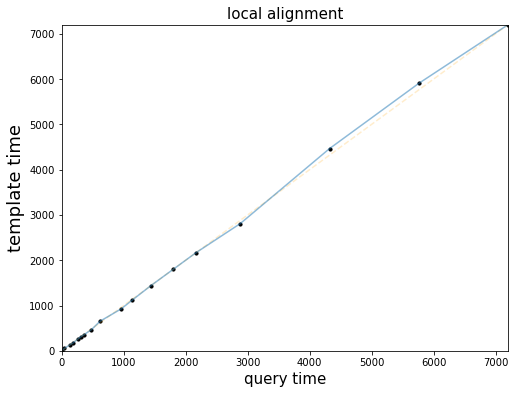

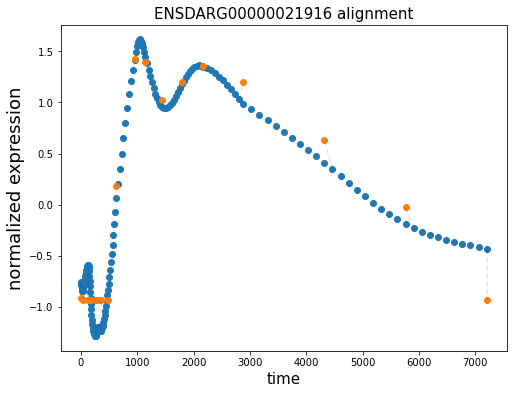

In [14]:
# TODO: more arguments need to be passed (verbose/plot etc)!

paths = bootstrap_alignment(template_tpms_inf, query_tpms, template_gene_clusters, cycles=2, tries=2, frac=0.2, filter_frac=0)